# Problem 2.5: Graph Learning with Graph Neural Networks
In this problem we will explore two Graph Learning tasks (Node Classification and Graph Classification) and how they can be solved with Graph Neural Networks.

Please fill in the gaps in the code blocks below and add answers to the questions in the text blocks. 

</span>$\color{red}{\text{Please write your own code.}}$

In [1]:
# Install required packages.
!python -m pip install --upgrade pip

import torch
print(torch.__version__)
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html torch-cluster -f https://pytorch-geometric.com/whl/torch-${torch.__version__}.html pyg-lib -f https://data.pyg.org/whl/torch-${torch.__version__}.html
            
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install networkx matplotlib tqdm scikit-learn gensim

!pip install  dgl -f https://data.dgl.ai/wheels/cu118/repo.html
!pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html

from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import os.path as osp
import networkx as nx

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2.1.0
Looking in links: https://data.pyg.org/whl/torch-2.1.0.html, https://pytorch-geometric.com/whl/torch-.1.0.html, https://data.pyg.org/whl/torch-.1.0.html
Looking in links: https://data.dgl.ai/wheels/cu118/repo.html
Looking in links: https://data.dgl.ai/wheels-test/repo.html


/opt/anaconda3/lib/python3.11/site-packages/torch_geometric/typing.py:84: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: dlopen(/opt/anaconda3/lib/python3.11/site-packages/libpyg.so, 0x0006): tried: '/opt/anaconda3/lib/python3.11/site-packages/libpyg.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS/opt/anaconda3/lib/python3.11/site-packages/libpyg.so' (no such file), '/opt/anaconda3/lib/python3.11/site-packages/libpyg.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64'))
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/opt/anaconda3/lib/python3.11/site-packages/torch_geometric/typing.py:166: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/opt/anaconda3/lib/python3.11/site-packages/libpyg.so, 0x0006): tried: '/opt/anaconda3/lib/python3.11/site-packages/libpyg.so' (mac

# Part 1: Node Classification with Graph Neural Networks

We will again use the `Cora` dataset, which is a **citation network** where nodes represent documents.
Each node is described by a 1433-dimensional bag-of-words feature vector.
Two documents are connected if there exists a citation link between them.
The task is to infer the category of each document (7 in total).

This dataset was first introduced by [Yang et al. (2016)](https://arxiv.org/abs/1603.08861) as one of the datasets of the `Planetoid` benchmark suite.
We again can make use [PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric) for an easy access to this dataset via [`torch_geometric.datasets.Planetoid`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid):

In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


### Training a Graph Neural Network (GNN)

We want to train a GNN using Pytorch Geometric's GNN operators.
Specifically, we will utilize Graph Convolutional Network layers (implemented via the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) module).

The **GCN layer** was introduced by [Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) and is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.

In [3]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


**(a) Visualize the node embeddings of the *untrained* GCN network in the plane.**




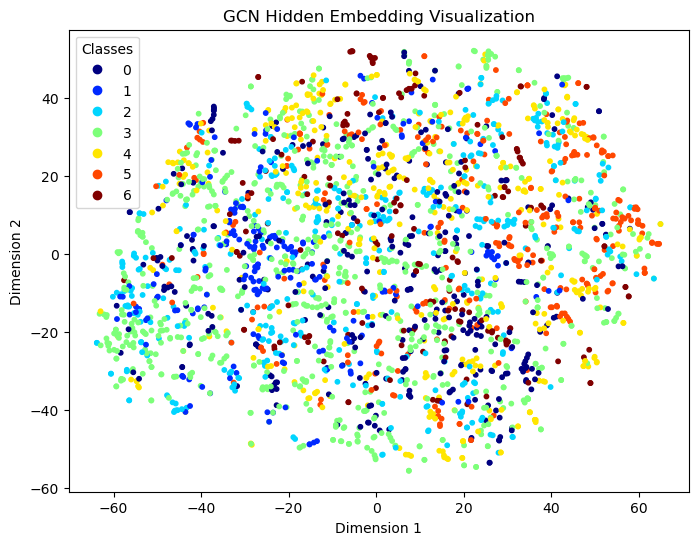

In [4]:
model = GCN(hidden_channels=16)
model.eval()

with torch.no_grad():
    out = model(data.x, data.edge_index)

############################
#  Implement visualization #
############################
def plot(out):
    embeddings_2d = TSNE(n_components=2, random_state=42).fit_transform(out.cpu().numpy())
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                        c=data.y.cpu().numpy(), cmap='jet', s=10)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title("GCN Hidden Embedding Visualization")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

plot(out)

Next we train our GNN. The node features `x` and the graph connectivity `edge_index` are the input to our GCN model.

In [5]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

def test():
    ##############################
    #  Implement a test function #
    ##############################
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    
    mask = data.test_mask
    correct = pred[mask].eq(data.y[mask]).sum().item()
    acc = correct / mask.sum().item()
    return acc


<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9465
Epoch: 002, Loss: 1.9419
Epoch: 003, Loss: 1.9363
Epoch: 004, Loss: 1.9290
Epoch: 005, Loss: 1.9199
Epoch: 006, Loss: 1.9140
Epoch: 007, Loss: 1.9079
Epoch: 008, Loss: 1.8992
Epoch: 009, Loss: 1.8876
Epoch: 010, Loss: 1.8764
Epoch: 011, Loss: 1.8656
Epoch: 012, Loss: 1.8626
Epoch: 013, Loss: 1.8460
Epoch: 014, Loss: 1.8329
Epoch: 015, Loss: 1.8225
Epoch: 016, Loss: 1.8167
Epoch: 017, Loss: 1.7995
Epoch: 018, Loss: 1.7878
Epoch: 019, Loss: 1.7716
Epoch: 020, Loss: 1.7568
Epoch: 021, Loss: 1.7563
Epoch: 022, Loss: 1.7342
Epoch: 023, Loss: 1.7092
Epoch: 024, Loss: 1.7015
Epoch: 025, Loss: 1.6671
Epoch: 026, Loss: 1.6757
Epoch: 027, Loss: 1.6609
Epoch: 028, Loss: 1.6355
Epoch: 029, Loss: 1.6339
Epoch: 030, Loss: 1.6102
Epoch: 031, Loss: 1.5964
Epoch: 032, Loss: 1.5721
Epoch: 033, Loss: 1.5570
Epoch: 034, Loss: 1.5445
Epoch: 035, Loss: 1.5093
Epoch: 036, Loss: 1.4889
Epoch: 037, Loss: 1.4776
Epoch: 038, Loss: 1.4704
Epoch: 039, Loss: 1.4263
Epoch: 040, Loss: 1.3972


**(b) After training the model, check its test accuracy.**

In [6]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8110


**(c) Replot the node embeddings and compare with your plot in part (a).**

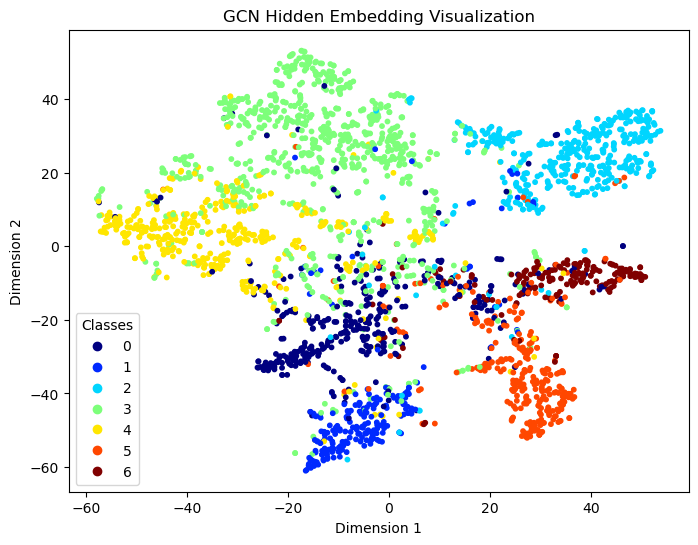

In [7]:
model.eval()

with torch.no_grad():
    out = model(data.x, data.edge_index)

############################
#  Implement visualization #
############################
plot(out)

**(d) How does the performance of your GNN change, when increasing the hidden feature dimensionality or the number of layers?** 

Try different hyperparameters and evaluate model performance via test accuracy and visualization. 


Number of Hidden channels = 1
Epoch: 100, Loss: 1.7185
Test Accuracy: 0.2970


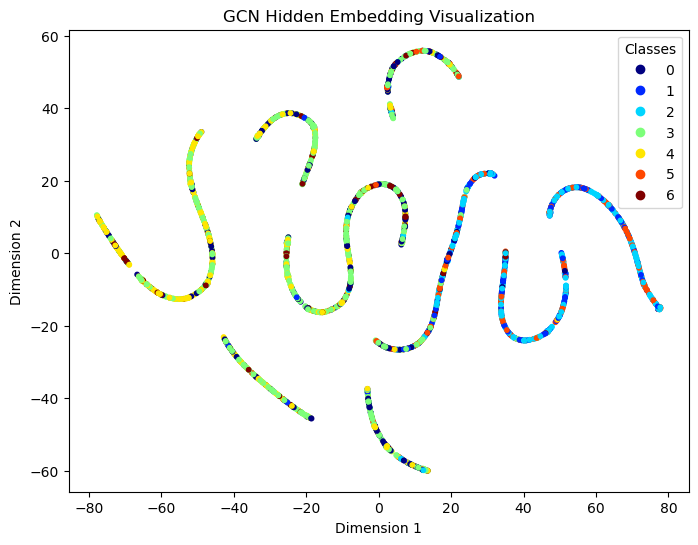

Number of Hidden channels = 2
Epoch: 100, Loss: 1.6153
Test Accuracy: 0.3570


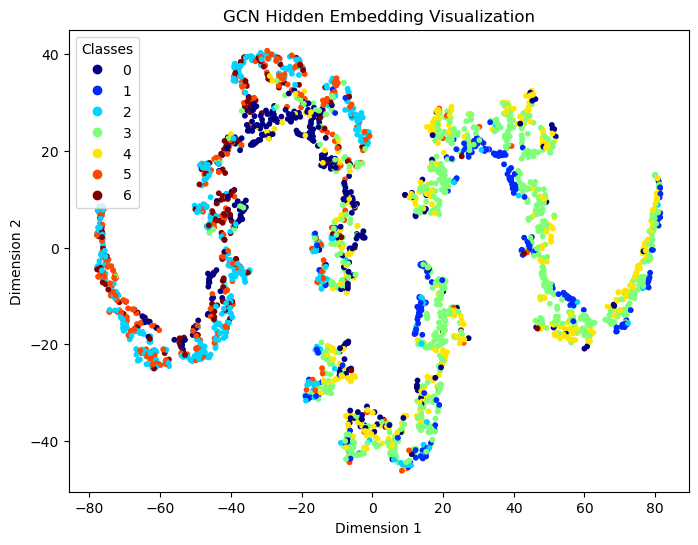

Number of Hidden channels = 4
Epoch: 100, Loss: 1.2823
Test Accuracy: 0.7330


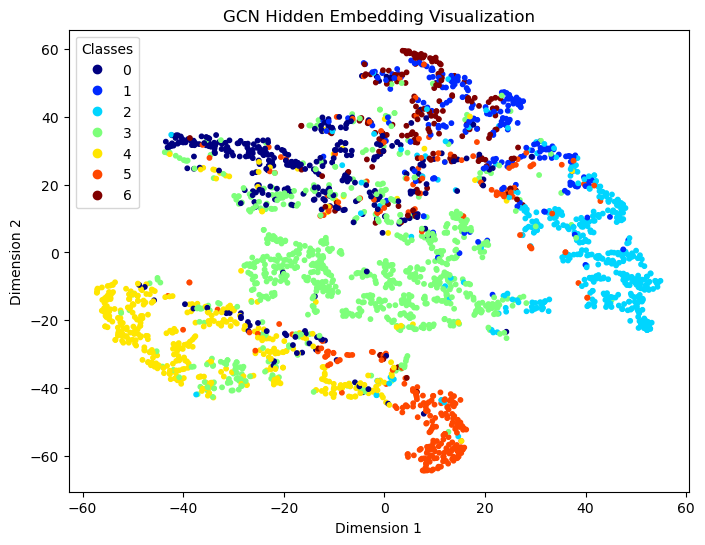

Number of Hidden channels = 8
Epoch: 100, Loss: 0.8302
Test Accuracy: 0.7770


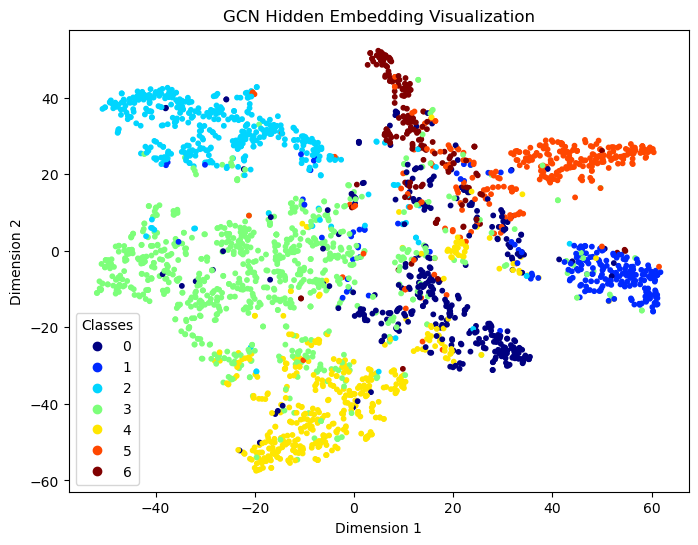

Number of Hidden channels = 16
Epoch: 100, Loss: 0.6375
Test Accuracy: 0.8110


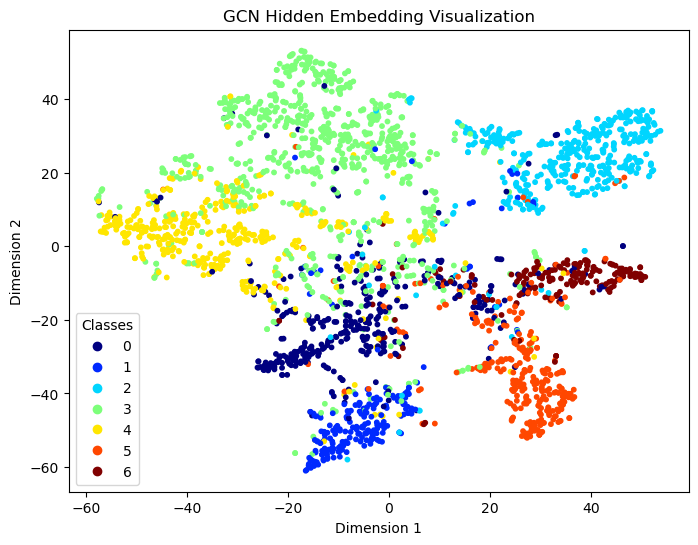

Number of Hidden channels = 32
Epoch: 100, Loss: 0.3438
Test Accuracy: 0.8050


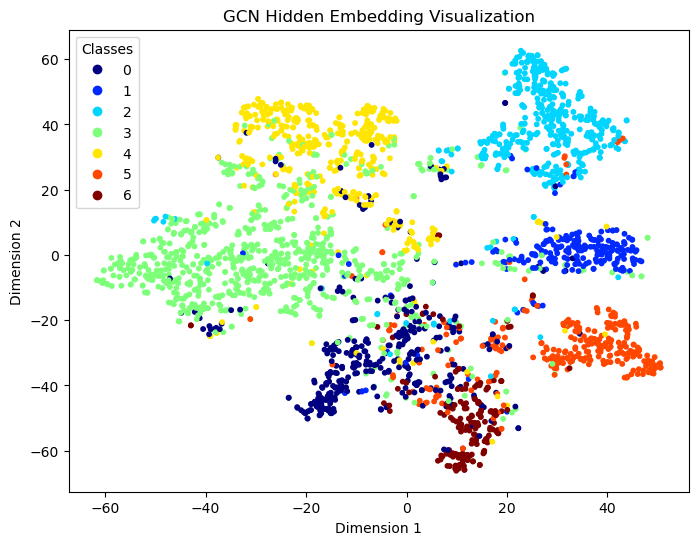

Number of Hidden channels = 64
Epoch: 100, Loss: 0.2648
Test Accuracy: 0.8130


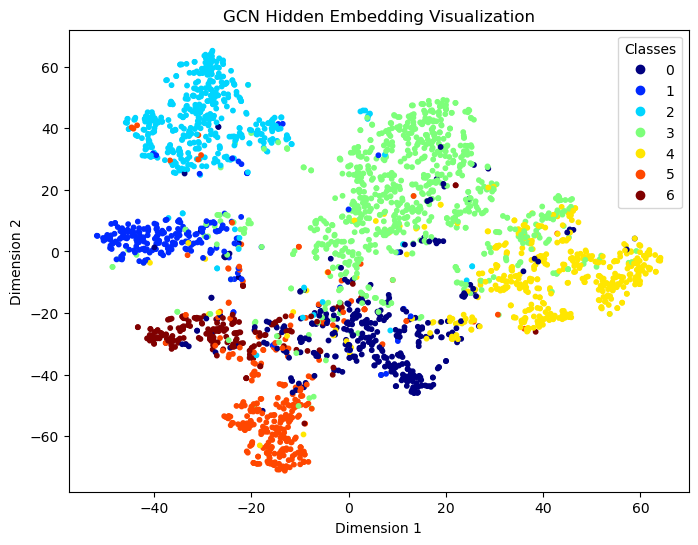

In [8]:
for num_channels in [1, 2, 4, 8, 16, 32, 64]:
    print(f"\033[1;31mNumber of Hidden channels = {num_channels}\033[0m")

    model = GCN(hidden_channels=num_channels)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(1, 101):
        loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    print(f'Test Accuracy: {test():.4f}')

    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
    plot(out)

# Part 2: Graph Classification with Graph Neural Networks

Graph classification refers to the problem of classifiying a set of **graphs** (in contrast to nodes), based on structural graph properties.
We want to learn embeddings of graph, which are linearly separable given a specific task.

Our graph classification task is **molecular property prediction**. Here, molecules are represented as graphs, and we want to infer whether a molecule inhibits HIV virus replication or not. We will use the **MUTAG** dataset, which is part of a collection of benchmark data sets releast by 
the TU Dortmund University ([**TUDatasets**](https://chrsmrrs.github.io/datasets/), also accessible via [`torch_geometric.datasets.TUDataset`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.TUDataset)).

In [9]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2


The MUTAG dataset has 188 graphs, we want to perform a binary classification task, i.e., each graph is in one of two classes.

We want to use the first 150 graphs as training graphs, and leave the remaining ones for testing:

In [10]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

## Mini-batching of graphs

Since graphs in graph classification datasets are usually small, a good idea is to **batch the graphs** before inputting them into a Graph Neural Network to guarantee full GPU utilization.
A standard approach is to stack adjacency matrices diagonally by creating a giant graph that holds multiple isolated subgraphs and concatenating node and target features in the node dimension.

This procedure has some crucial advantages over other batching procedures:

1. GNN operators that rely on a message passing scheme do not need to be modified since messages are not exchanged between two nodes that belong to different graphs.

2. There is no computational or memory overhead since adjacency matrices are saved in a sparse fashion holding only non-zero entries, *i.e.*, the edges.

PyTorch Geometric automatically takes care of **batching multiple graphs into a single giant graph** with the help of the [`torch_geometric.data.DataLoader`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.DataLoader) class:

In [11]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2636], x=[1188, 7], edge_attr=[2636, 4], y=[64], batch=[1188], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2506], x=[1139, 7], edge_attr=[2506, 4], y=[64], batch=[1139], ptr=[65])

Step 3:
Number of graphs in the current batch: 22
DataBatch(edge_index=[2, 852], x=[387, 7], edge_attr=[852, 4], y=[22], batch=[387], ptr=[23])



Here, we opt for a `batch_size` of 64, leading to 3 (randomly shuffled) mini-batches, containing all $2 \cdot 64+22 = 150$ graphs.

Furthermore, each `Batch` object is equipped with a **`batch` vector**, which maps each node to its respective graph in the batch:

$$
\textrm{batch} = [ 0, \ldots, 0, 1, \ldots, 1, 2, \ldots ]
$$

## Training a Graph Neural Network (GNN)

We train a GNN for graph classification as follows:

1. Embed each node by performing multiple rounds of message passing
2. Aggregate node embeddings into a unified graph embedding (**readout layer**)
3. Train a final classifier on the graph embedding

Here, we implement the **readout layer** as the average of the node embeddings:

$$
\mathbf{x}_{\mathcal{G}} = \frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \mathcal{x}^{(L)}_v
$$

PyTorch Geometric provides this functionality via [`torch_geometric.nn.global_mean_pool`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.glob.global_mean_pool), which takes in the node embeddings of all nodes in the mini-batch and the assignment vector `batch` to compute a graph embedding of size `[batch_size, hidden_channels]` for each graph in the batch.

We again utilize GCN layers ([`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv)) with $\mathrm{ReLU}(x) = \max(x, 0)$ activation for obtaining localized node embeddings, before we apply our final classifier on top of a graph readout layer.


**(e) Implement the GNN.**

In [12]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)
    
    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings via GCN layers + ReLU activations
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()

        # 2. Readout layer (global mean pool across nodes)
        x = global_mean_pool(x, batch)

        # 3. Final classifier
        x = self.lin(x)
        return F.softmax(x, dim=1)


model = GCN(hidden_channels=64)

Train the GNN.

In [13]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=64)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()

    ##############################
    #  Implement a test function #
    ##############################
    correct = 0
    
    with torch.no_grad():
        for data in loader:
            # Forward pass (no gradients required)
            out = model(data.x, data.edge_index, data.batch)

            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())

    # Overall accuracy is the number of correct predictions divided by all samples
    return correct / len(loader.dataset)

<IPython.core.display.Javascript object>

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


**(f) After training the model, check its test accuracy.**

In [14]:
train()
print("Test Accuracy:", test(test_loader))

Test Accuracy: 0.7368421052631579


Neighborhood normalization can decrease the performance of GNNs in distinguishing between certain graph structures ([Morris et al. (2018)](https://arxiv.org/abs/1810.02244)). 
An alternative formulation by Morris et al. omits neighborhood normalization and adds a simple skip-connection to the GNN layer in order to preserve central node information:

$$
\mathbf{x}_v^{(\ell+1)} = \mathbf{W}^{(\ell + 1)}_1 \mathbf{x}_v^{(\ell)} + \mathbf{W}^{(\ell + 1)}_2 \sum_{w \in \mathcal{N}(v)} \mathbf{x}_w^{(\ell)}
$$

This layer is implemented under the name [`GraphConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GraphConv) in PyTorch Geometric. 

**(g) Modify your GNN architecture and recompute the test accuracy.**

In [15]:
from torch_geometric.nn import GraphConv

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels) # Add your code
        self.conv2 = GraphConv(hidden_channels, hidden_channels) # Add your code
        self.conv3 = GraphConv(hidden_channels, hidden_channels) # Add your code
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return F.softmax(x, dim = 1)

model = GNN(hidden_channels=64)


In [16]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GNN(hidden_channels=64)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

########################
#  Check test accuracy #
########################
train()
print("Test Accuracy:", test(test_loader))

<IPython.core.display.Javascript object>

GNN(
  (conv1): GraphConv(7, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)
Test Accuracy: 0.7894736842105263


*This notebook is adapted from a tutorial by Matthias Fey.*